# 01 - Data Preprocessing & Cleaning
This notebook loads the Heart Disease dataset, performs EDA, handles missing values, encodes categorical variables, scales numeric features, and saves preprocessing artifacts.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import json, joblib

In [25]:
DATA_PATH = Path(r"D:\Books and Courses\Machine Learning\Sprints x Microsoft Summer Camp - AI and Machine Learning\Comprehensive Machine Learning Full Pipeline on Heart Disease UCI Dataset (Graduation Project)\Heart_Disease_Project\data\heart_disease.xls")
df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [26]:
# Basic info about the dataset
print(df.shape)
print(df.dtypes)

(303, 14)
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object


In [27]:
# Missing values overview 
mv = df.isna().sum().sort_values(ascending=False)
print(mv)

ca          4
thal        2
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64


<Figure size 640x480 with 0 Axes>

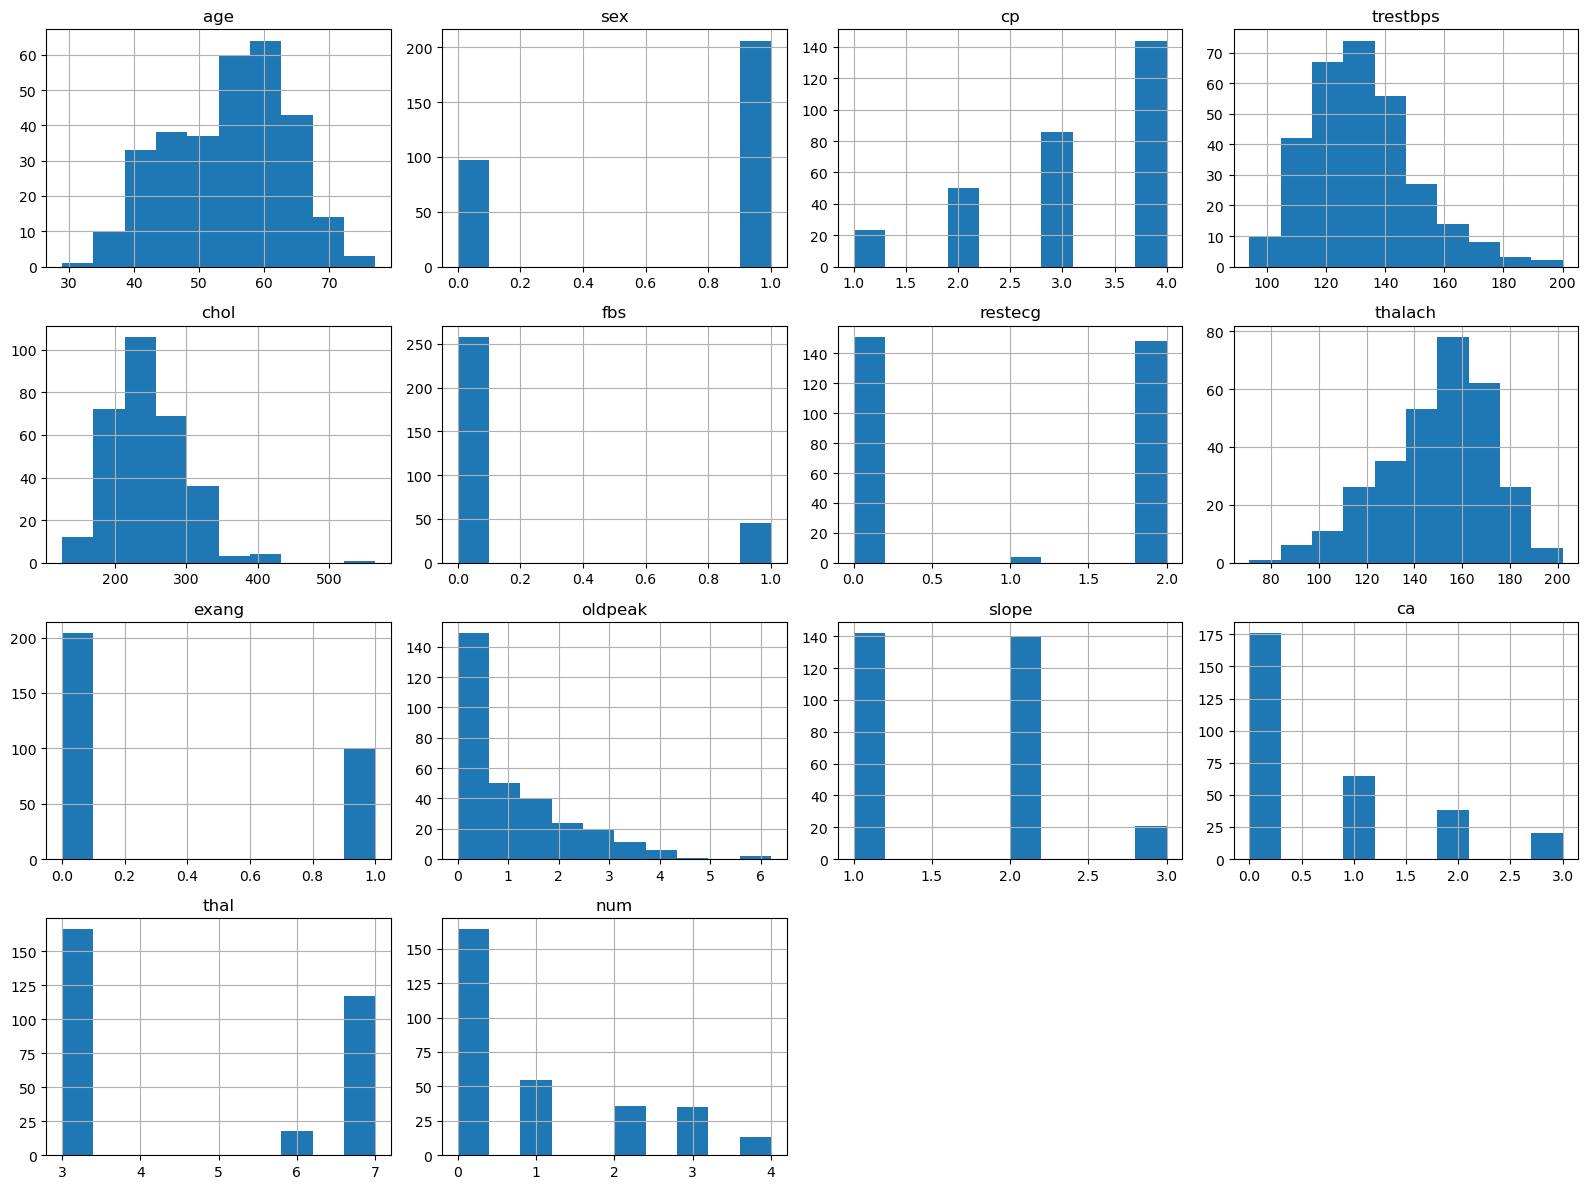

In [28]:
# EDA - Histograms for numerical features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure()
df[num_cols].hist(figsize=(16, 12))
plt.tight_layout()
plt.show()

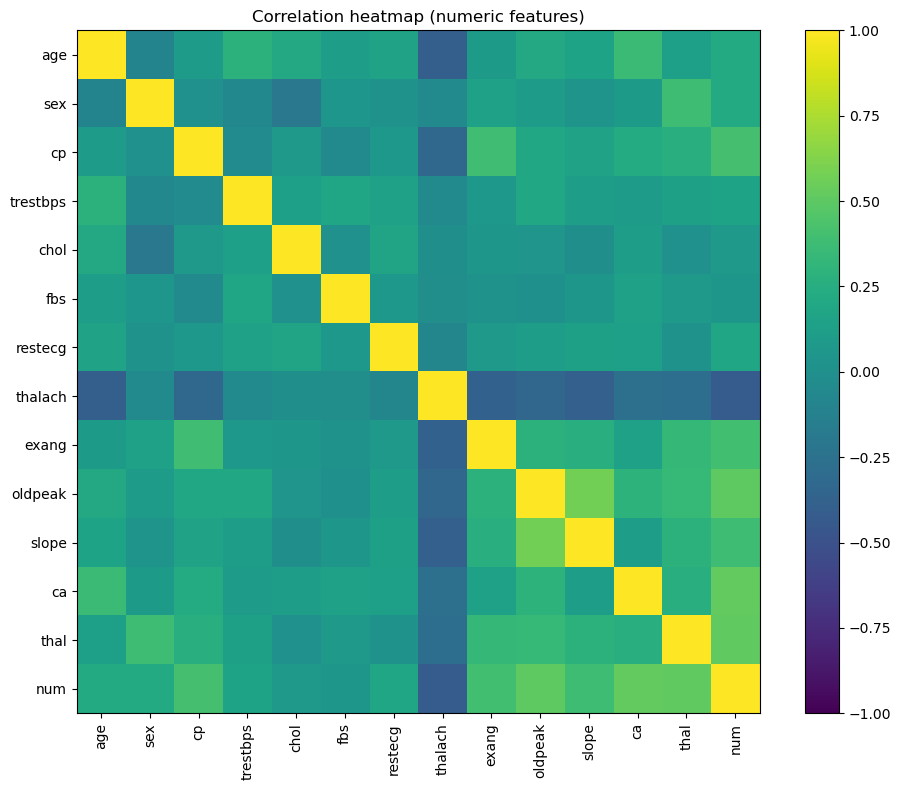

In [29]:
# Correlation heatmap for numeric features
corr = df[num_cols].corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation heatmap (numeric features)')
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.tight_layout()
plt.show()

In [30]:
# Convert Cleveland-style target (0..4) to binary (0:no disease, 1:disease)
if df['num'].nunique() > 2:
    df['num'] = (df['num'] > 0).astype(int)

X = df.drop(columns=['num'])
y = df['num'].astype(int)

In [31]:
# Identify categorical columns heuristically (non-numeric or low-cardinality integers)
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
# Treat small-cardinality integer columns as categorical (e.g., sex, fbs, exang, cp)
for c in X.select_dtypes(include=[np.number]).columns:
    if X[c].nunique() <= 5:
        if c not in cat_cols:
            cat_cols.append(c)
num_cols = [c for c in X.columns if c not in cat_cols]
print('Numeric:', num_cols)
print('Categorical:', cat_cols)

Numeric: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [32]:
# Split dataset (stratify for classification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessor pipeline

# Scale numeric features to [0,1], one-hot encode categorical features
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Fit preprocessor on training data 
preprocessor.fit(X_train)

# Save artifacts for later use
import os
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)
joblib.dump(preprocessor, 'models/preprocessor.pkl')

# Schema helps Streamlit UI build inputs later 
schema = {
    'features': {c: {'type': ('numeric' if c in num_cols else 'categorical')}
                 for c in X.columns},
    'target': 'num'
}
with open('data/feature_schema.json', 'w', encoding='utf-8') as f:
    json.dump(schema, f, indent=2)

# Saving cleaned datasets 
X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)
np.savez('data/cleaned_train.npz', X=X_train_t, y=y_train.values)
np.savez('data/cleaned_test.npz', X=X_test_t, y=y_test.values)
print('Saved: models/preprocessor.pkl, data/feature_schema.json, data/cleaned_*.npz')

Saved: models/preprocessor.pkl, data/feature_schema.json, data/cleaned_*.npz
